# Set Up Environment



In [25]:
!pip install rdkit python-dotenv pandas numpy matplotlib loguru py3dmol

In [2]:
import os
import pickle
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import requests

from dotenv import load_dotenv

from rdkit import Chem
from rdkit.Chem.QED import qed as rdkit_qed
from rdkit.Chem.QED import qed
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import Descriptors

from IPython.display import display, clear_output

API Key and URL

In [3]:
# Load environment variables from .env file. Add API key to .env file.
load_dotenv()

# Access your API key
API_KEY = os.getenv("API_KEY")

if API_KEY:
    print("NVIDIA API Key loaded successfully.")
else:
    print("NVIDIA API Key not found. Make sure it's set in your .env file or as a system environment variable.")
    raise ValueError("API_KEY is not set. Please create a .env file with your API_KEY.")

# --- API Setup ---
invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/molmim/generate"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}
session = requests.Session()

NVIDIA API Key loaded successfully.


# Starting Molecule

Original QED: 0.5857591504571036


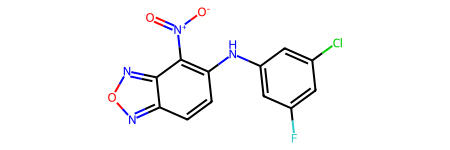

In [4]:
# Input SMILE string
smis = "C1=CC2=NON=C2C(=C1NC3=CC(=CC(=C3)Cl)F)[N+](=O)[O-]"

mol = Chem.MolFromSmiles(smis)
qed_score = rdkit_qed(mol)
print(f"Original QED: {qed_score}")
mol

## CMA-ES Optimization

In [6]:
# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
num_min_sims = 3
min_sims = np.linspace(0.1, 0.7, num_min_sims)

In [7]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

In [10]:
# Loop through each minimum similarity value
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'smiles': [], 'num_smiles': [], 'tanimoto_similarity': [], 'qed_score': []}

    # Create the request payload
    payload = {
      "smi": smis,
      "algorithm": "CMA-ES",
      "num_molecules": 10,
      "property_name": "QED",
      "minimize": False,
      "min_similarity": min_sim,
      "particles": 20,
      "iterations": 2,
      "scaled_radius": 1
    }

    # Send the request and get the response
    response = session.post(invoke_url, headers=headers, json=payload)
    response.raise_for_status()
    response_json = response.json()
    print(f"*************** min_sim: {min_sim} ********************")
    print(f"response_json: \n"
          f"{response_json}")

    # Extract the generated SMILES
    gen_smiles_list = [i['sample'] for i in ast.literal_eval(response_json['molecules'])]
    print(f"gen_smiles_list: \n"
          f"{gen_smiles_list}")
    # Get the molecule objects out of valid SMILES
    valid_mol_list = [mol for smiles in gen_smiles_list if (mol := Chem.MolFromSmiles(smiles))]
    # Convert to canonical SMILES & deduplicate
    canonical_smiles = set()
    for mol in valid_mol_list:
        canonical_smi = Chem.MolToSmiles(mol, canonical=True)
        canonical_smiles.add(canonical_smi)
    canonical_smiles_list = list(canonical_smiles)
    print(f"canonical_smiles_list: \n"
          f"{canonical_smiles_list}")

    # Calculate Tanimoto similarity and QED score for each valid SMILES
    for smiles in canonical_smiles_list:
        tanimoto = tanimoto_similarity(smiles, smis)
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        min_sim_results['tanimoto_similarity'].append(tanimoto)
        min_sim_results['qed_score'].append(qed_score)

    # Update min_sim_results - get the average of Tanimoto and QED scores, store generated SMILES
    min_sim_results['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results['qed_score'] = np.mean(min_sim_results['qed_score'])
    min_sim_results['num_smiles'] = len(canonical_smiles_list)
    min_sim_results['smiles'] = canonical_smiles_list

    # Store the results for this min_sim
    results[min_sim] = min_sim_results

*************** min_sim: 0.1 ********************
response_json: 
{'molecules': '[{"sample": "C=C(F)C(F)(F)CC(=O)c1[nH]n2c(=O)cc(Cl)n2c1Cl", "score": 0.877613363067063}, {"sample": "C=C(Cl)CN(C(=O)C1=CCN2NC=CC=C12)C(C)C", "score": 0.8563517768550072}, {"sample": "CC1=C(C)C(=C2CC=C(n3ccc(Cl)n3)N2C)C(=O)C1", "score": 0.7450886348522938}, {"sample": "Cc1cc(C(F)(F)F)cccc2nc3cc(=N)nc3n12", "score": 0.687041524526122}, {"sample": "C=C(C)CC(=O)N1CC(O)(CNC(=O)[C@@H]2C=CC(=O)N=N2)C1", "score": 0.6705122884131778}, {"sample": "N#CCCN(C(=O)C1=Nc2c(F)cc([N+](=O)[O-])cc2C1)C1=NCCc2ccccc21", "score": 0.5744827819907009}, {"sample": "C=C(Cl)CN(C)C(=O)C1=CC([N+](=O)[O-])=CC2=NS(=O)(=O)CCN12", "score": 0.5259432901074417}, {"sample": "CC(CC(F)(F)F)=NNC(=O)c1c([N+](=O)[O-])cn2c1C=CC2", "score": 0.5254837147628005}, {"sample": "C=C(C[N+](=O)[O-])N/C(N)=C1\\\\C(=O)N=C2C=CC=CC=C21", "score": 0.4413223300094401}, {"sample": "C=C(COC(=O)C(C#N)=c1ccc2c(n1)N=CC=2)[N+](=O)[O-]", "score": 0.4208335644717804}]', 

In [13]:
def lipinski_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # invalid SMILES

    # Calculate Lipinski's properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hba = Descriptors.NumHAcceptors(mol)
    hbd = Descriptors.NumHDonors(mol)

    return mw, logp, hba, hbd

,smiles,qed_score,tanimoto_similarity,min_sim,mw,logp,hba,hbd
0,C=C(Cl)C(=O)N=C1C(Cl)=NC(=O)c2nc3ccc(F)cn3c(=O...,0.717364,0.164557,0.7,367.123,1.6929,5,0
1,O=C(c1cn[c-](F)c1)N1CCc2nccc(Cl)c2C1,0.751355,0.112500,0.7,278.694,2.1865,3,0
2,FC1=C=Cn2[nH]c(Cl)c3c1ccc2NC=C3,0.664211,0.095890,0.7,235.649,3.3838,2,2
3,C=C1C=CCC(C(=O)N2CCn3c(=O)cc[c-]3C2)=C1,0.710878,0.062500,0.7,255.297,1.3519,3,0
4,CC(=O)N=C1CCc2c(N)cc(=O)[nH]c2C1,0.662909,0.066667,0.7,219.244,0.4333,3,2
5,CN(C(=O)c1ccnc2ccccc12)C1CN(C(=O)OC(C)(C)C)C1,0.842450,0.070588,0.7,341.411,2.9261,4,0
6,O=C1[C@@H]2[C@H](C(=O)N1c1cc(Cl)cc(CO)c1)[C@H]...,0.672547,0.112676,0.7,303.745,2.1438,3,1
7,CCOC(=O)C1=CNC2=NC(=O)/C(=c3/ncn4c3=CNC=C4)C2=C1,0.658036,0.054348,0.7,323.312,-1.2815,7,2
8,CN(C(=O)c1c[c-]2ncccc2n1)C1CCC(F)(F)CC1,0.799351,0.073171,0.7,292.309,2.9986,3,0
9,CN(CC=C(Cl)Cl)CC1=CC2=[N+]=C(F)CN2C2=NC(=O)C=C...,0.710860,0.076923,0.7,368.219,1.7478,3,0


CSV report saved as 'min_sim_results_report.csv'.
Plots saved as 'min_sim_results_plots.png'.


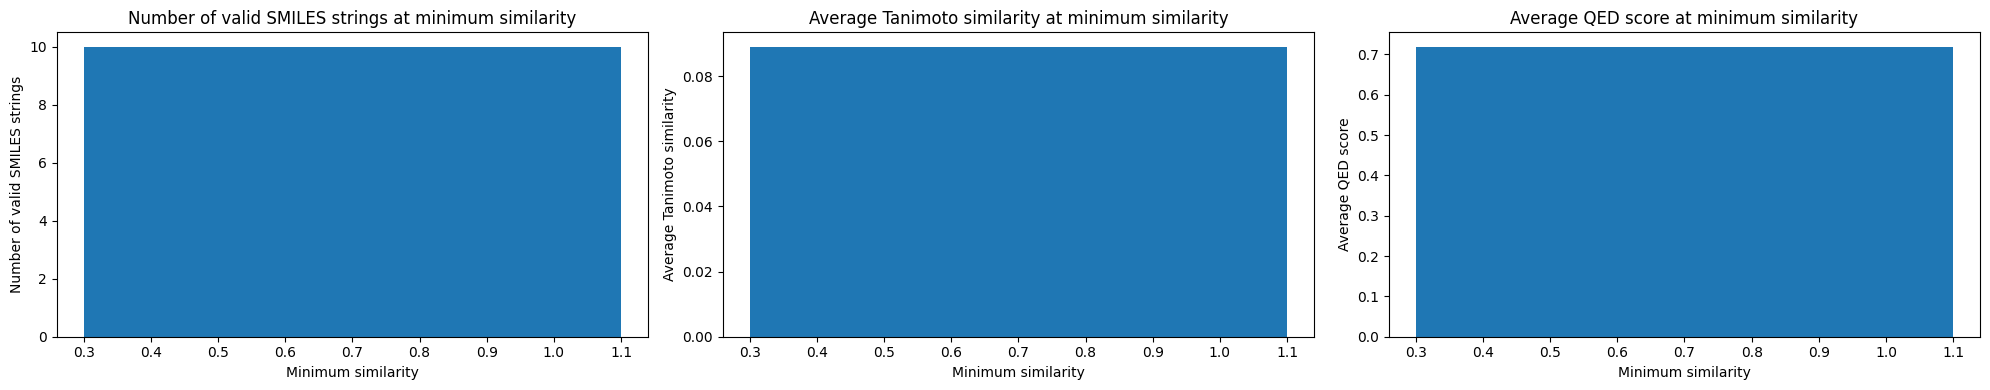

In [24]:

# Create a list to store the data for the report
report_data = []

for smiles in min_sim_results['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    qed_score = qed(mol)
    tanimoto = tanimoto_similarity(smiles, smis)

    # Calculate Lipinski properties
    lipinski = lipinski_properties(smiles)
    if lipinski:
        mw, logp, hba, hbd = lipinski
    else:
        mw, logp, hba, hbd = None, None, None, None

    report_data.append({
        'smiles': smiles,
        'qed_score': qed_score,
        'tanimoto_similarity': tanimoto,
        'min_sim': min_sim,
        'mw': mw,
        'logp': logp,
        'hba': hba,
        'hbd': hbd,
    })

# Create a pandas DataFrame from the report data
report_df = pd.DataFrame(report_data)

# Display the DataFrame
display(report_df)

# Save the DataFrame as a CSV file
csv_filename = 'min_sim_results_report.csv'
report_df.to_csv(csv_filename, index=False)
print(f"CSV report saved as '{csv_filename}'.")

# Save the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.bar([min_sim], [min_sim_results['num_smiles']])
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at minimum similarity')

# Plot the average Tanimoto similarity
plt.subplot(1, 3, 2)
plt.bar([min_sim], [min_sim_results['tanimoto_similarity']])
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at minimum similarity')

# Plot the average QED score
plt.subplot(1, 3, 3)
plt.bar([min_sim], [min_sim_results['qed_score']])
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at minimum similarity')

plt.tight_layout()
plot_filename = 'min_sim_results_plots.png'
plt.savefig(plot_filename)
print(f"Plots saved as '{plot_filename}'.")


,smiles,qed_score,tanimoto_similarity,min_sim,mw,logp,hba,hbd
0,N#CCCN(C(=O)C1=Nc2c(F)cc([N+](=O)[O-])cc2C1)C1...,0.574483,0.152174,0.1,405.389,3.10768,6,0
1,Cc1cc(C(F)(F)F)cccc2nc3cc(=N)nc3n12,0.687042,0.108108,0.1,278.237,2.68919,4,1
2,C=C(Cl)CN(C)C(=O)C1=CC([N+](=O)[O-])=CC2=NS(=O...,0.525943,0.119048,0.1,360.779,0.29930,6,0
3,CC(CC(F)(F)F)=NNC(=O)c1c([N+](=O)[O-])cn2c1C=CC2,0.525484,0.134146,0.1,316.239,2.48120,5,1
4,C=C(COC(=O)C(C#N)=c1ccc2c(n1)N=CC=2)[N+](=O)[O-],0.420834,0.108434,0.1,284.231,-0.41412,7,0
5,C=C(Cl)CN(C(=O)C1=CCN2NC=CC=C12)C(C)C,0.856352,0.047059,0.1,279.771,2.13370,3,1
6,C=C(C)CC(=O)N1CC(O)(CNC(=O)[C@@H]2C=CC(=O)N=N2)C1,0.670512,0.071429,0.1,306.322,-0.44070,5,2
7,CC1=C(C)C(=C2CC=C(n3ccc(Cl)n3)N2C)C(=O)C1,0.745089,0.102564,0.1,289.766,3.23370,4,0
8,C=C(C[N+](=O)[O-])N/C(N)=C1\C(=O)N=C2C=CC=CC=C21,0.441322,0.113924,0.1,272.264,0.57030,5,2
9,C=C(F)C(F)(F)CC(=O)c1[nH]n2c(=O)cc(Cl)n2c1Cl,0.877613,0.089744,0.1,328.077,2.72520,4,1


CSV report saved as 'results_report.csv'.


KeyError: 'index'

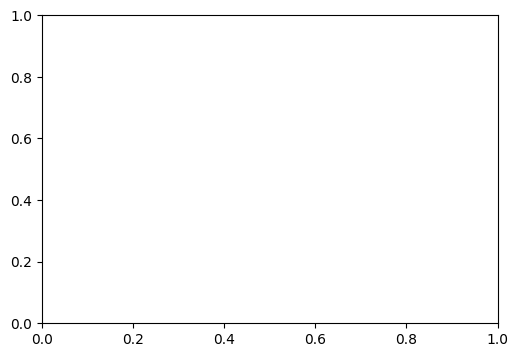

In [23]:
# prompt: Print and download out a report for min_sim_results. create a table of SMILE String generated, QED scores, Tanimoto scores, lipinski_properties, and also include plots generated.

# Create a list to store the data for the report
report_data = []

for min_sim, min_sim_results in results.items():
    for smiles in min_sim_results['smiles']:
        mol = Chem.MolFromSmiles(smiles)
        qed_score = qed(mol)
        tanimoto = tanimoto_similarity(smiles, smis)

        # Calculate Lipinski properties
        lipinski = lipinski_properties(smiles)
        if lipinski:
            mw, logp, hba, hbd = lipinski
        else:
            mw, logp, hba, hbd = None, None, None, None

        report_data.append({
            'smiles': smiles,
            'qed_score': qed_score,
            'tanimoto_similarity': tanimoto,
            'min_sim': min_sim,
            'mw': mw,
            'logp': logp,
            'hba': hba,
            'hbd': hbd,
        })

# Create a pandas DataFrame from the report data
report_df = pd.DataFrame(report_data)

# Display the DataFrame
display(report_df)

# Save the DataFrame as a CSV file
csv_filename = 'results_report.csv'
report_df.to_csv(csv_filename, index=False)
print(f"CSV report saved as '{csv_filename}'.")

# Save and download the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.plot(report_df['index'], report_df['num_smiles'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each minimum similarity')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(report_df['index'], report_df['tanimoto_similarity'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each minimum similarity')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(report_df['index'], report_df['qed_score'], linestyle='-', marker='o')
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at each minimum similarity')

plt.tight_layout()
plt.savefig('min_sim_results_plots.png')
plt.show()

